In [1]:
import json
from dateutil import parser
import TweetExtraction as te
import pandas as pd
import DataProcessing as dp
import statsmodels.api as sm
from statsmodels.api import families
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
from statsmodels.stats.diagnostic import het_white
from datetime import datetime as dt
import random as rnd
from statsmodels.discrete.count_model import NegativeBinomialP, ZeroInflatedNegativeBinomialP
from statsmodels.api import OLS
from statsmodels.tools import add_constant
import seaborn as sb

chunk_files = [
    './data/id_chunk0.jsonl', 
    './data/id_chunk1.jsonl', 
    './data/id_chunk2.jsonl', 
    './data/id_chunk3.jsonl', 
    './data/id_chunk4.jsonl',
    './data/id_chunk_comp0.jsonl',
    './data/id_chunk_comp1.jsonl',
    './data/id_chunk_comp2.jsonl',
    './data/id_chunk_comp3.jsonl',
    './data/id_chunk_comp4.jsonl',
    './data/id_chunk_comp5.jsonl',
    './data/id_chunk_comp6.jsonl',
    './data/id_chunk_comp7.jsonl',
    './data/id_chunk_comp8.jsonl',
    './data/id_chunk_comp9.jsonl'
]

In [4]:
# tweets_df = te.get_all_tweets(chunk_files)
# tweets_df.to_pickle('./tweets.pkl')
# combined_df = dp.merge_preprocess_climate_tweets(
#     './data/climateTweets.csv',
#     './tweets.pkl',
#     retweets=False
# )
# combined_df.to_pickle('combined_tweets.pkl')

In [2]:
def transformations(df):

    new_df = df.copy()

    new_df['log_text_len'] = new_df['text'].map(lambda x: np.log(len(x) + 1))
    new_df['text_len'] = new_df['text'].map(lambda x: len(x))
    
    new_df['log_user_followers'] = np.log(new_df['user_followers'] + 1)
    new_df['log_user_favorites'] = np.log(new_df['user_favorites'] + 1)
    new_df['log_user_friends'] = np.log(new_df['user_friends'] + 1)
    new_df['log_user_freq'] = np.log(new_df['user_freq'] + 1)
    new_df['bool_user_verified'] = new_df['user_verified'].map(lambda x: int(x == True))

    new_df['bool_hashtags'] = new_df['hashtags'].map(lambda x: int(x > 0))
    new_df['bool_mentions'] = new_df['mentions'].map(lambda x: int(x > 0))
    new_df['bool_urls'] = new_df['urls'].map(lambda x: int(x > 0))
    new_df['bool_media'] = new_df['media'].map(lambda x: int(x > 0))
    
    new_df['bool_sensitive'] = new_df['sensitive'].map(lambda x: int(x == True))
    new_df['bool_aggressive'] = new_df['aggressive']
    new_df['bool_denier'] = new_df['denier']

    new_df['bool_retweets'] = new_df['retweets'].map(lambda x: int(x > 0))
    new_df['log_retweets'] = new_df['retweets'].map(lambda x: np.log(x + 1))

    new_df['bool_favorites'] = new_df['favorites'].map(lambda x: int(x > 0))
    new_df['log_favorites'] = new_df['favorites'].map(lambda x: np.log(x + 1))

    new_df['emotionality'] = new_df['sentiment'].map(lambda x: np.abs(x))
    new_df['bool_sentiment'] = new_df['sentiment'].map(lambda x: int(x > 0))
    new_df['log_sentiment'] = new_df['sentiment'].map(lambda x: np.log(x + 1))

    new_df['bool_awareness'] = new_df['topic'].map(lambda x: int(x == 'Awareness'))
    new_df['bool_consumption'] = new_df['topic'].map(lambda x: int(x == 'Consumption'))
    new_df['bool_emissions'] = new_df['topic'].map(lambda x: int(x == 'Emissions'))
    new_df['bool_global'] = new_df['topic'].map(lambda x: int(x == 'Global'))
    new_df['bool_ideology'] = new_df['topic'].map(lambda x: int(x == 'Ideology'))
    new_df['bool_intervention'] = new_df['topic'].map(lambda x: int(x == 'Intervention'))
    new_df['bool_politics'] = new_df['topic'].map(lambda x: int(x == 'Politics'))
    new_df['bool_trump'] = new_df['topic'].map(lambda x: int(x == 'Trump'))
    new_df['bool_undefined'] = new_df['topic'].map(lambda x: int(x == 'Undefined'))
    new_df['bool_weather'] = new_df['topic'].map(lambda x: int(x == 'Weather'))

    return new_df

In [3]:
combined_df = pd.read_pickle('combined_tweets.pkl').drop_duplicates()

In [4]:
translated_df = transformations(combined_df)

In [10]:
awareness = translated_df[translated_df['bool_awareness'] == 1][['text']]

In [16]:
with pd.option_context('display.max_colwidth', None):
    display(awareness.sample(5))

,text
3830284,"‘Mustang Means Freedom’: Why Ford Is Saving an American Icon https://t.co/85hIFqD25I\nAs long as gas prices CAFE standards are kept too low , the auto industry will turn out more &amp; more gas-guzzling trucks &amp; SUVs &amp; speed up global warming."
1646563,"A picture NatGeo put out a while ago. They claimed the bear was dying because of industry induced climate change. False. The truth: the bear was dying of old age (which they knew). Also the polar bear population is growing. In the 60s there were approx 6000, presently, 28,000. https://t.co/sLvZfVp8sN"
3311222,RT @wildlifeaction Save polar bears - and people! - from global warming polluters before it's too late: http://bit.ly/dX4izx
1616712,#excellent #globalwarming #lexapro #medicine #pharmacy http://62.99.70.17/crisp.htm
6582811,Article: Bangkok Car Free Day this Sunday to raise awareness of global warming http://t.co/fDaX4El


In [60]:
user_predictors = [
    'log_user_followers', 'bool_user_verified', 'log_user_friends', 'log_user_freq', 'log_user_favorites'
]
structural_predictors = [
    'bool_hashtags', 'bool_mentions', 'bool_urls', 'bool_media', 'bool_sensitive', 'log_text_len'
]
content_predictors = [
    'sentiment', 'bool_aggressive'
]
framing_predictors = [
    'bool_denier', 'bool_awareness', 'bool_consumption', 'bool_emissions', 'bool_global', 
    'bool_ideology', 'bool_intervention', 'bool_politics', 'bool_trump', 
    'bool_weather'
]
numeric_predictors = user_predictors + structural_predictors + content_predictors + framing_predictors

## Descriptive Data Analysis

In [6]:
hashtagless = translated_df[translated_df['bool_hashtags'] == 0]
keyword_filter = hashtagless['text'].map(lambda x: 'climate change' in x.lower() or 'global warming' in x.lower() or 'climate hoax' in x.lower())
with pd.option_context('display.max_colwidth', None):
    display(hashtagless[~keyword_filter][['text']])

,text
1227,@Lid79908481's account is temporarily unavailable because it violates the Twitter Media Policy. Learn more.
2093,"It's happening right now, not very far! a few hours by plane from home! #poverty#climatechange#UN#refugee#asia#humantight#climate#chine#usa# https://t.co/6fuXIw0gVd"
5636,窓が割れるので東急はクソ
6161,@na_co_UoxoU @Candy みんなにはほよりとかほよとかほよちゃんとかって呼ばれるよ🤟🏻\n呼びやすいように呼んでもらえれば( ᐡ｡› ·̫ ‹｡ᐡ )♡
6187,@Pamela_moreiraa @netopaodequeijo @mnnau_ ta
...,...
7672654,#irma#climatechange\nRead Isaiah ch24\nThe Lord's devastation of the earth\nHe will lay it waste &amp; it will affect ALL\nas all bear guilt ......
7674988,"Fascinating : ""Where is the remotest place on earth?"" http://bit.ly/O2yQ6 #ecology#climatechange#environment"
7676079,@Peston So if the US gets its trade deal and the NHS is privatised how does that help the working class Robert?
7677817,Every Argument Against Veganism | Ed Winters | TEDxBathUniversity https://t.co/NeDuHXnOkb via @YouTube #meat#dairy#vegan#animals#health#awareness#bethechange#climatechange#gogreen#environmental#love#earthlinged#amazing#food#ethical#hearthealth#cancerawareness


In [7]:
np.round(translated_df['topic'].value_counts() / len(translated_df), 2)

Global          0.25
Weather         0.19
Intervention    0.15
Undefined       0.11
Politics        0.09
Trump           0.07
Emissions       0.07
Ideology        0.04
Consumption     0.03
Awareness       0.02
Name: topic, dtype: float64

In [8]:
len(translated_df[translated_df['bool_retweets'] == 0]) / len(translated_df)

0.8068691348272744

In [30]:
with pd.option_context('display.max_columns', None, 'display.float_format', '{:20,.2f}'.format):
    display(translated_df[['retweets']].describe())

,retweets
count,"7,641,399.00"
mean,1.82
std,118.83
min,0.00
25%,0.00
50%,0.00
75%,0.00
max,"149,655.00"


<AxesSubplot: >

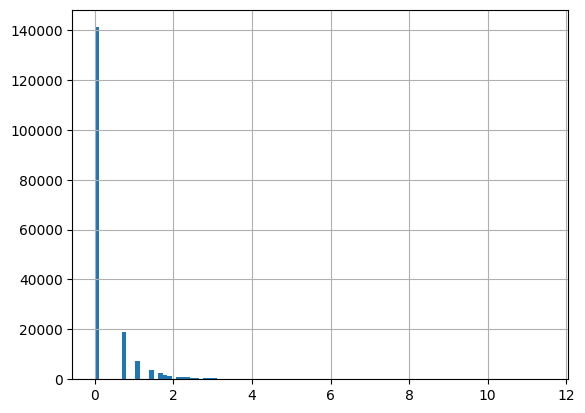

In [40]:
translated_df[translated_df['bool_awareness'] == 1]['log_retweets']

In [44]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

gini(translated_df['retweets'].sample(100000).to_numpy())

0.9602011230411546

## Modeling

In [10]:
# equation = f"retweets ~ {' + '.join(numeric_predictors)}"
# # alpha estimation
# lambda_model = sm.glm(
#     equation,
#     data = translated_df,
#     family=families.Poisson()
# ).fit()

# translated_df['lambdas'] = lambda_model.mu
# translated_df['dependent'] = translated_df.apply(lambda x: ((x['retweets'] - x['lambdas'])**2 - x['lambdas']) / x['lambdas'], axis=1)

# alpha_model = sm.ols(
#     "dependent ~ lambdas - 1",
#     data=translated_df
# ).fit()

# print(alpha_model.params)

# model = sm.glm(equation, data=translated_df, family=families.NegativeBinomial(alpha=120.223555)).fit()
# print(model.summary())

In [52]:
ols_model = OLS(
    endog=translated_df['retweets'],
    exog=add_constant(translated_df[numeric_predictors]),
).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:               retweets   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     624.4
Date:                Thu, 12 Jan 2023   Prob (F-statistic):               0.00
Time:                        17:04:52   Log-Likelihood:            -4.7344e+07
No. Observations:             7641399   AIC:                         9.469e+07
Df Residuals:                 7641375   BIC:                         9.469e+07
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -12.7406      0

In [53]:
pois_model = Poisson(
    endog=translated_df['retweets'],
    exog=add_constant(translated_df[numeric_predictors]),
).fit_regularized()
print(pois_model.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.379057234326717
            Iterations: 77
            Function evaluations: 84
            Gradient evaluations: 77
                          Poisson Regression Results                          
Dep. Variable:               retweets   No. Observations:              7641399
Model:                        Poisson   Df Residuals:                  7641375
Method:                           MLE   Df Model:                           23
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                  0.4847
Time:                        17:05:37   Log-Likelihood:            -3.3462e+07
converged:                       True   LL-Null:                   -6.4941e+07
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

In [61]:
nb_model = NegativeBinomialP(
    endog=translated_df['retweets'],
    exog=add_constant(translated_df[numeric_predictors]),
).fit_regularized()
print(nb_model.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.8226540307332144
            Iterations: 162
            Function evaluations: 164
            Gradient evaluations: 162


/Users/matthewbone/Documents/Coding/VSCode/twitterChambers/twitEnv/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


                     NegativeBinomialP Regression Results                     
Dep. Variable:               retweets   No. Observations:              7641399
Model:              NegativeBinomialP   Df Residuals:                  7641375
Method:                           MLE   Df Model:                           23
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                  0.1450
Time:                        20:35:04   Log-Likelihood:            -6.2862e+06
converged:                       True   LL-Null:                   -7.3522e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -9.3176      0.015   -619.204      0.000      -9.347      -9.288
log_user_followers     0.7008      0.001    806.738      0.000       0.699       0.702
bool_user_verified  

In [33]:
def interpret_results(bool_predictors, model):

    mean_retweets = translated_df['retweets'].mean()

    for var in bool_predictors:
        print(f"{var}:")
        multiplier = np.exp(model.params[var])
        if 'bool' in var:
            false_avg = translated_df[translated_df[var] == 0]['retweets'].mean()
            true_avg = translated_df[translated_df[var] == 1]['retweets'].mean()
            print(f"false avg: {false_avg:.2f}, true avg: {true_avg:.2f}, multiplier: {multiplier:.4f}, E(diff): {(false_avg * (multiplier - 1)):.2f}", end="\n\n")
        elif 'log' in var:
            mod_multiplier = multiplier * (np.log(2) - np.log(1))
            print(f"multiplier: {multiplier:.4f}, E(diff): {mean_retweets * (mod_multiplier - 1):.2f}", end="\n\n")
        else:
            print(f"multiplier: {multiplier:.4f}, E(diff): {(mean_retweets * (multiplier - 1)):.2f}", end="\n\n")

interpret_results(numeric_predictors, model)

log_user_followers:
multiplier: 2.0153, E(diff): 0.72

bool_user_verified:
false avg: 0.84, true avg: 16.73, multiplier: 1.2750, E(diff): 0.23

log_user_friends:
multiplier: 0.8190, E(diff): -0.79

log_user_freq:
multiplier: 0.5296, E(diff): -1.15

log_user_favorites:
multiplier: 1.2120, E(diff): -0.29

bool_hashtags:
false avg: 1.81, true avg: 1.84, multiplier: 1.2654, E(diff): 0.48

bool_mentions:
false avg: 2.24, true avg: 1.13, multiplier: 0.6179, E(diff): -0.86

bool_urls:
false avg: 1.83, true avg: 1.82, multiplier: 0.8005, E(diff): -0.36

bool_media:
false avg: 1.36, true avg: 4.36, multiplier: 1.9823, E(diff): 1.33

bool_sensitive:
false avg: 1.83, true avg: 0.81, multiplier: 0.7752, E(diff): -0.41

log_text_len:
multiplier: 2.4238, E(diff): 1.24

sentiment:
multiplier: 0.7370, E(diff): -0.48

bool_aggressive:
false avg: 1.55, true avg: 2.36, multiplier: 1.3172, E(diff): 0.49

bool_denier:
false avg: 1.94, true avg: 0.70, multiplier: 0.6408, E(diff): -0.70

bool_awareness:
fals

## Validation

### Check for retweet distribtuion

<AxesSubplot: >

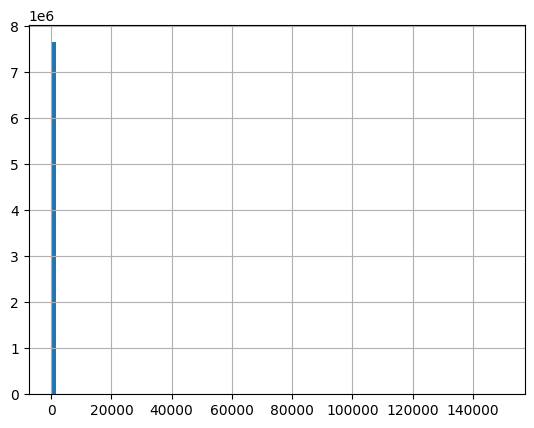

In [7]:
translated_df['retweets'].hist(bins=100)

<AxesSubplot: >

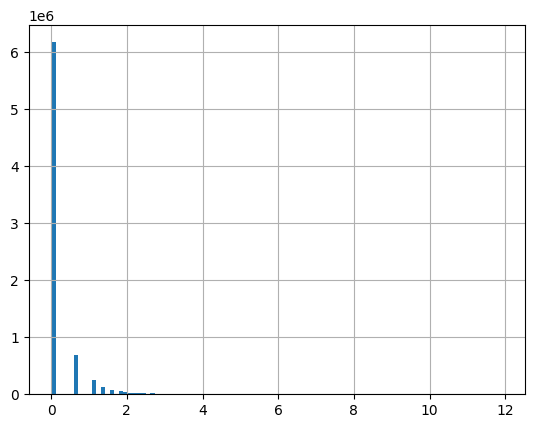

In [8]:
translated_df['log_retweets'].hist(bins=100)

### Check for predictor normality

In [16]:
viral_retweets = translated_df['retweets'].quantile(.9999)
viral_favorites = translated_df['favorites'].quantile(.99)
print(f"A tweet needs {viral_retweets} retweets to be in the 99th percentile")
print(f"A tweet needs {viral_favorites} likes to be in the 99th percentile")

A tweet needs 1196.7203999981284 retweets to be in the 99th percentile
A tweet needs 30.0 likes to be in the 99th percentile


In [24]:
translated_df['retweets'].sort_values().tail(1000).mean() * np.exp(1) - translated_df['retweets'].sort_values().tail(1000).mean()

6972.098628873593

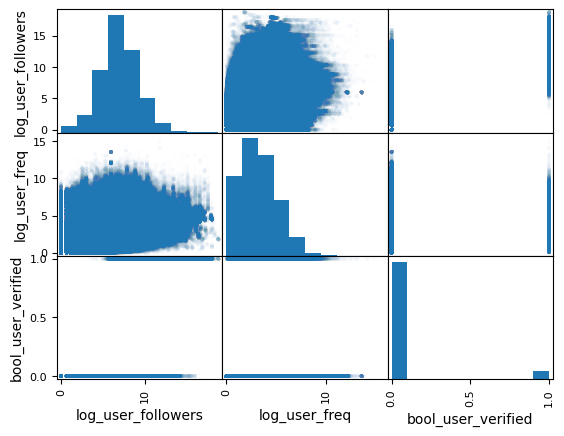

In [45]:
pd.plotting.scatter_matrix(translated_df[user_predictors], alpha=.01)
plt.show()

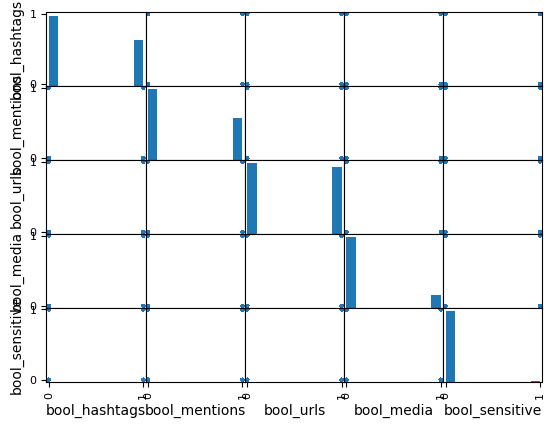

In [43]:
pd.plotting.scatter_matrix(translated_df[structural_predictors], alpha=.01)
plt.show()

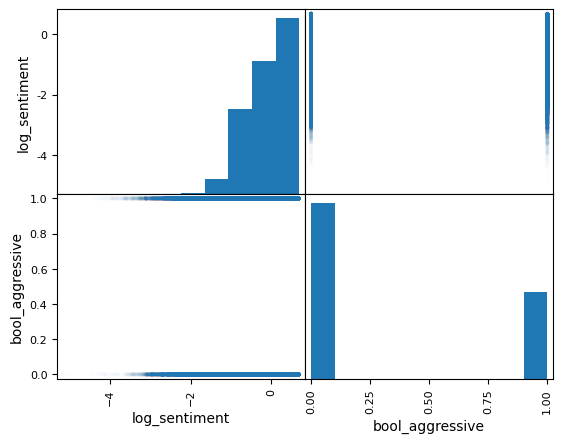

In [17]:
pd.plotting.scatter_matrix(translated_df[content_predictors], alpha=.01)
plt.show()

### Check for multicollinearity

In [44]:
translated_df[numeric_predictors + ['retweets']].corr().style.background_gradient(cmap='viridis')

,log_user_followers,log_user_freq,bool_user_verified,bool_hashtags,bool_mentions,bool_urls,bool_media,bool_sensitive,sentiment,bool_aggressive,bool_denier,log_text_len,retweets
log_user_followers,1.000000,0.319605,0.426491,0.181751,-0.046514,0.200911,0.270182,-0.007746,0.078661,-0.053345,-0.073237,0.132978,0.030771
log_user_freq,0.319605,1.000000,-0.004193,-0.060328,-0.144310,0.012192,0.051696,0.013310,-0.043531,-0.017841,0.024044,-0.096119,-0.002732
bool_user_verified,0.426491,-0.004193,1.000000,0.030278,-0.004053,0.079043,0.114148,-0.013681,0.032894,-0.013932,-0.048318,0.059581,0.032185
bool_hashtags,0.181751,-0.060328,0.030278,1.000000,-0.044404,0.217343,0.278992,-0.009061,0.217800,-0.057845,-0.087848,0.171047,0.000103
bool_mentions,-0.046514,-0.144310,-0.004053,-0.044404,1.000000,-0.201987,-0.069094,-0.014928,-0.014311,-0.080619,0.104679,0.200947,-0.004515
bool_urls,0.200911,0.012192,0.079043,0.217343,-0.201987,1.000000,0.151505,0.058602,0.131619,-0.082970,-0.146063,0.084903,-0.000053
bool_media,0.270182,0.051696,0.114148,0.278992,-0.069094,0.151505,1.000000,0.001906,0.186381,-0.111796,-0.083647,0.241874,0.009145
bool_sensitive,-0.007746,0.013310,-0.013681,-0.009061,-0.014928,0.058602,0.001906,1.000000,-0.004191,-0.004865,-0.005371,-0.002914,-0.000575
sentiment,0.078661,-0.043531,0.032894,0.217800,-0.014311,0.131619,0.186381,-0.004191,1.000000,-0.172333,-0.190096,0.047854,-0.000298
bool_aggressive,-0.053345,-0.017841,-0.013932,-0.057845,-0.080619,-0.082970,-0.111796,-0.004865,-0.172333,1.000000,0.088582,-0.001690,0.003209


### Check for scaling

In [116]:
with pd.option_context('display.max_columns', None):
    display(translated_df[numeric_predictors + ['retweets', 'favorites']].describe())

,user_followers,user_freq,user_verified,hashtags,mentions,urls,media,sensitive,sentiment,aggressive,denier,text_len,retweets,favorites
count,7.641399e+06,7.641399e+06,7.641399e+06,7.641399e+06,7.641399e+06,7.641399e+06,7.641399e+06,7.641399e+06,7.641399e+06,7.641399e+06,7.641399e+06,7.641399e+06,7.641399e+06,7.641399e+06
mean,6.998314e+00,3.196882e+00,6.178031e-02,3.972072e-01,3.751724e-01,4.858261e-01,1.547357e-01,4.580837e-03,2.945579e-02,3.311149e-01,9.192440e-02,4.847850e+00,1.822278e+00,3.880582e+00
std,2.345853e+00,1.827748e+00,2.407561e-01,4.893196e-01,4.841674e-01,4.997991e-01,3.616525e-01,6.752668e-02,4.388744e-01,4.706143e-01,2.889192e-01,4.342152e-01,1.188313e+02,3.687232e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.942049e-01,0.000000e+00,0.000000e+00,6.931472e-01,0.000000e+00,0.000000e+00
25%,5.564520e+00,1.776011e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.786715e-01,0.000000e+00,0.000000e+00,4.615121e+00,0.000000e+00,0.000000e+00
50%,6.927558e+00,3.030122e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.593018e-02,0.000000e+00,0.000000e+00,4.875197e+00,0.000000e+00,0.000000e+00
75%,8.357494e+00,4.420997e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,4.404407e-01,1.000000e+00,0.000000e+00,4.976734e+00,0.000000e+00,1.000000e+00
max,1.870836e+01,1.578227e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.901308e-01,1.000000e+00,1.000000e+00,6.933423e+00,1.496550e+05,3.636540e+05


### Check for Heteroscedasticity

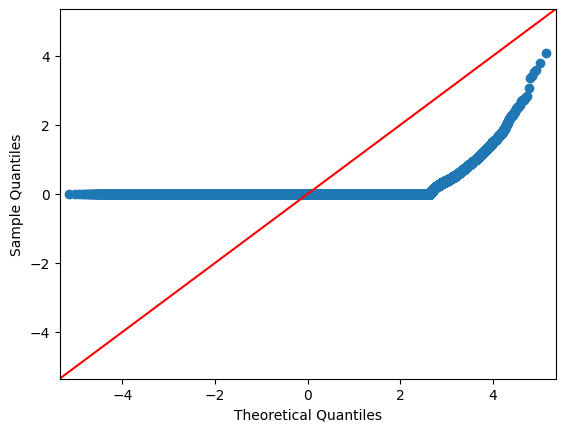

In [40]:
preds = model.predict(translated_df[numeric_predictors])
sm.qqplot(preds, line='45')
plt.show()

/Users/matthewbone/Documents/Coding/VSCode/twitterChambers/twitEnv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'true value')

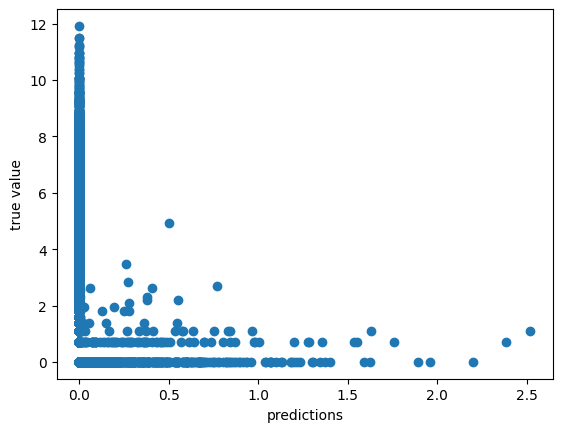

In [37]:
plt.scatter(preds, np.log(translated_df['retweets']))
plt.xlabel('predictions')
plt.ylabel('true value')

In [57]:
display(nb_model.aic)
display(pois_model.aic)
display(ols_model.aic)

12572505.375581509

66924295.14265388

94687749.214773